In [1]:
from ay_torch import *

# Variational Auto Encoder test

Refs.

- https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
- https://github.com/hsinyilin19/ResNetVAE/blob/master/modules.py
- https://qiita.com/kenchin110100/items/7ceb5b8e8b21c551d69a
- https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24

In [83]:
# NOTE: TResNetDecoder is defined in ay_torch

In [3]:
net= TResNet18(in_channels=3, out_channels=10)
input_size= (1,3,32,32)
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 32, 32)


/home/akihikoy/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                        Output Shape              Param #
TResNet                                       --                        --
├─Sequential: 1-1                             [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                            [1, 32, 32, 32]           864
│    └─BatchNorm2d: 2-2                       [1, 32, 32, 32]           64
│    └─ReLU: 2-3                              [1, 32, 32, 32]           --
├─Sequential: 1-2                             [1, 32, 16, 16]           --
│    └─Conv2d: 2-4                            [1, 32, 16, 16]           9,216
│    └─BatchNorm2d: 2-5                       [1, 32, 16, 16]           64
│    └─ReLU: 2-6                              [1, 32, 16, 16]           --
├─Sequential: 1-3                             [1, 64, 8, 8]             --
│    └─Conv2d: 2-7                            [1, 64, 8, 8]             18,432
│    └─BatchNorm2d: 2-8                       [1, 64, 8, 8]             128
│    └─ReLU

In [4]:
net= TResNet18Decoder(in_channels=100, out_imgshape=(3,32,32))
input_size= (1,100)
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 100)


Layer (type:depth-idx)                        Output Shape              Param #
TResNetDecoder                                --                        --
├─Linear: 1-1                                 [1, 512]                  51,712
├─Unflatten: 1-2                              [1, 512, 1, 1]            --
├─Sequential: 1-3                             [1, 256, 2, 2]            --
│    └─TResBlock: 2-1                         [1, 512, 1, 1]            --
│    │    └─Sequential: 3-1                   [1, 512, 1, 1]            4,720,640
│    │    └─Sequential: 3-2                   [1, 512, 1, 1]            --
│    │    └─ReLU: 3-3                         [1, 512, 1, 1]            --
│    └─Upsample: 2-2                          [1, 512, 2, 2]            --
│    └─TResBlock: 2-3                         [1, 256, 2, 2]            --
│    │    └─Sequential: 3-4                   [1, 256, 2, 2]            1,770,496
│    │    └─Sequential: 3-5                   [1, 256, 2, 2]            131,5

In [5]:
class TResNetVAE(torch.nn.Module):
  def __init__(self, in_imgshape, layers=[2, 2, 2, 2], encoder_args=None, decoder_args=None, latent_dim=256, n_hiddens=1, hidden_channels=768, p_dropout=0.0):
    super(TResNetVAE,self).__init__()
    default_encoder_args= {'expansion':1}
    encoder_args= MergeDict(default_encoder_args,encoder_args) if encoder_args else default_encoder_args
    default_decoder_args= {'expansion':1}
    decoder_args= MergeDict(default_decoder_args,decoder_args) if decoder_args else default_decoder_args
    self.encoder= TResNet(TResBlock, **encoder_args, layers=layers, in_channels=in_imgshape[0], with_fc=False)
    ndim_encoder= torch.flatten(self.encoder(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    self.fc_base= torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Linear(ndim_encoder, hidden_channels),
          torch.nn.ReLU(),
          torch.nn.Dropout(p_dropout),
          *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens)],
          torch.nn.Dropout(p_dropout),
          )
    self.fc_mu= torch.nn.Linear(hidden_channels, latent_dim)
    self.fc_logvar= torch.nn.Linear(hidden_channels, latent_dim)
    
    self.decoder= TResNetDecoder(TResBlock, **decoder_args, layers=layers, in_channels=latent_dim, out_imgshape=in_imgshape)

  def forward(self, x):
    x_encoded= self.encoder(x)
    h= self.fc_base(x_encoded)
    mu, log_var= self.fc_mu(h), self.fc_logvar(h)
    std= torch.exp(log_var/2.)
    if self.training:
      q= torch.distributions.Normal(mu, std)
      z= q.rsample()
    else:
      z= mu
    x_reconstructed= self.decoder(z)
    return x_reconstructed, z, mu, std

class TVAELoss(torch.nn.Module):
  def __init__(self):
    super(TVAELoss,self).__init__()
    self.log_scale= torch.nn.Parameter(torch.Tensor([0.0]))
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    x_reconstructed,z,mu,std= y_pred
    x= y_trg
    self.log_scale.to(x.device)
    dstr= torch.distributions.Normal(x_reconstructed, torch.exp(self.log_scale.to(x.device)))
    reconst_loss= dstr.log_prob(x).sum(dim=(1, 2, 3))
    p= torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q= torch.distributions.Normal(mu, std)
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)
    kld= (log_qzx-log_pz).sum(-1)
    elbo= (kld-reconst_loss).mean()
    return elbo

## VAE for MNIST

In [6]:
def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(32),
        torchvision.transforms.ToTensor()
      ])

In [7]:
dset_train= torchvision.datasets.MNIST(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.MNIST(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

/home/akihikoy/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


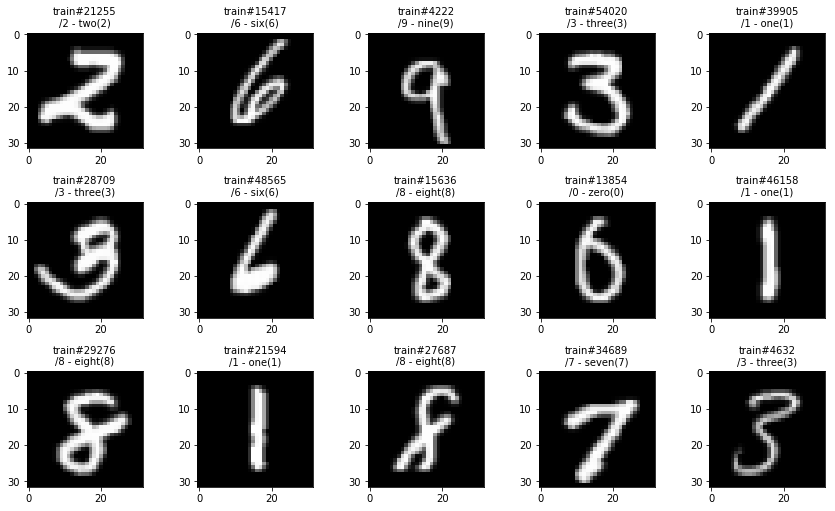

In [8]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

In [9]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResNetVAE(in_imgshape=in_imgshape)

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TVAELoss()
f_metric= None

def tfm_batch(batch):
  x,y= batch
  return x,x  #NOTE: We return x as the output to learn it.

logger= TLogger()
disp= TDisp()

In [10]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
net
torchinfo.summary(net, input_size)
# [y.shape for y in Eval(net,[dset_train[0][0]],device=device)]

input_size=(1, 1, 32, 32)


Layer (type:depth-idx)                             Output Shape              Param #
TResNetVAE                                         --                        --
├─TResNet: 1-1                                     [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                            [1, 32, 32, 32]           288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 32, 32]           64
│    │    └─ReLU: 3-3                              [1, 32, 32, 32]           --
│    └─Sequential: 2-2                             [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-4                            [1, 32, 16, 16]           9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 16, 16]           64
│    │    └─ReLU: 3-6                              [1, 32, 16, 16]           --
│    └─Sequential: 2-3                             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%


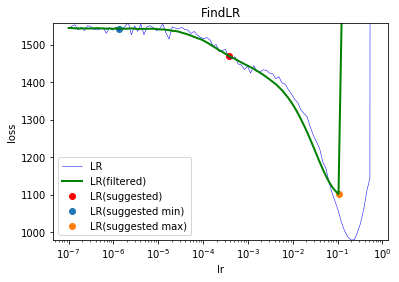

lr= 0.0003715352290971726, lr_min=1.3182567385564072e-06, lr_max=0.10471285480508992


In [11]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, r_div=4, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	1259.68642037	1108.01266965	nan	39.366890
1	992.30218207	965.88950926	nan	39.643449
2	966.75321489	965.99685999	nan	39.769029
3	966.22355193	965.27424612	nan	39.727968
4	965.15455839	964.07668543	nan	41.419399
5	963.73879159	962.36351684	nan	40.425829
6	962.55789009	961.44658141	nan	40.657021
7	961.72884859	960.80680935	nan	40.543891
8	961.07586410	960.32077085	nan	40.789791
9	960.73075330	960.56782133	nan	40.488392


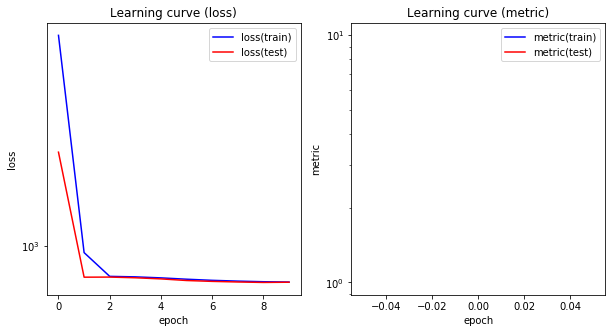

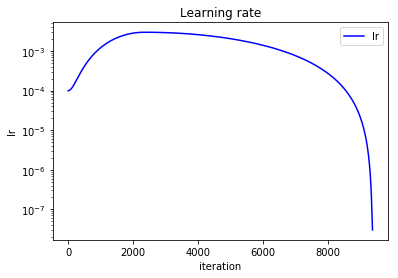

In [12]:
lr_min,lr_max= 1.e-4, 3.e-3
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
# Fit(net, n_epoch=10, lr=1.e-3, 
#     opt=opt, f_loss=f_loss, f_metric=f_metric,
#     dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
#     callbacks=(logger.Callbacks(),disp.Callbacks()),
#     device=device)
logger.Plot()
logger.PlotLR()

In [ ]:
#DEBUG
batch=next(batch for batch in dl_test)
# x,y_trg,pred= PredBatch(net, batch, tfm_batch=tfm_batch, device=device)
if next(net.parameters()).device != device:  net.to(device)
x,y= tfm_batch(batch)
x= x.to(device)
y= tuple(yi.to(device) for yi in y) if isinstance(y,(tuple,list)) else y.to(device)
# pred= net(x)
x_encoded= net.encoder(x)
h= net.fc_base(x_encoded)
mu, log_var= net.fc_mu(h), net.fc_logvar(h)
std= torch.exp(log_var/2.)
print(f'x_encoded={x_encoded}')
print(f'h={h}')
print(f'mu={mu}')
print(f'log_var={log_var}')
print(f'std={std}')
q= torch.distributions.Normal(mu, std)
z= q.rsample()
x_reconstructed= net.decoder(z)
pred= x_reconstructed, z, mu, std

print(f'x={x}')
print(f'y_trg={y_trg}')
print(f'pred={pred}')
# FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
#     opt=opt, f_loss=f_loss, f_metric=f_metric,
#     dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
#     callbacks=(logger.Callbacks(),disp.Callbacks()),
#     device=device)


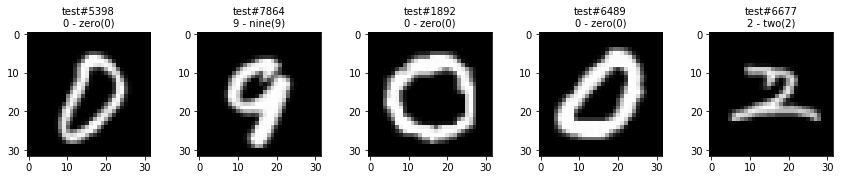

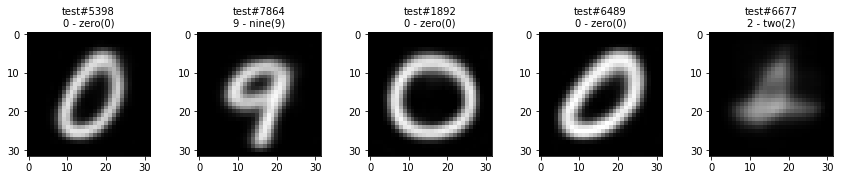

In [19]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= torch.clamp(Eval(net,imgs,device=device)[0].cpu(),0,1)
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
plabels= [f'pred#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels, rows=1)
PlotImgGrid(pred, labels, rows=1)

## VAE for CIFAR-10

In [20]:
def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(64),
        torchvision.transforms.Pad(10, padding_mode='constant'),  #'reflect'
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomAffine(degrees=10, scale=(1.,1.1), shear=(-0.2,0.2,-0.2,0.2)),
        torchvision.transforms.CenterCrop(64),
        torchvision.transforms.RandomResizedCrop(32, scale=(0.75,1.), ratio=(1.,1.)),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(32),
        torchvision.transforms.ToTensor()
      ])

In [21]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


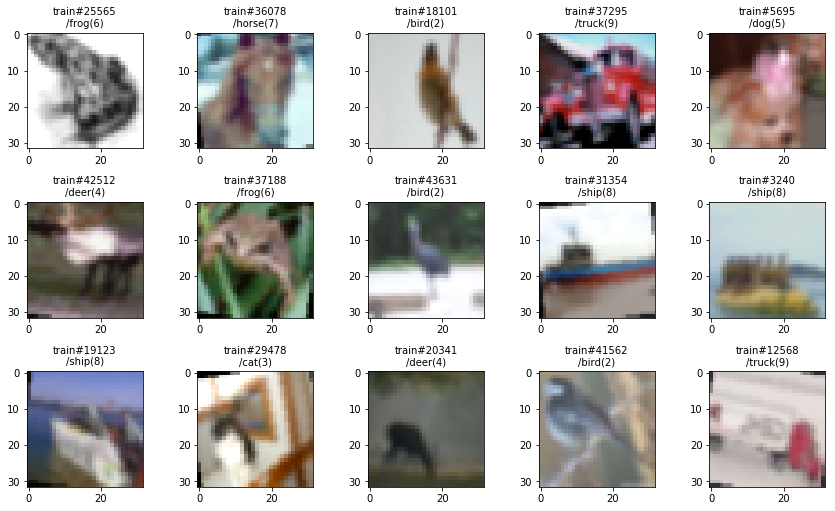

In [22]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

In [35]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResNetVAE(in_imgshape=in_imgshape, latent_dim=512)

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TVAELoss()
f_metric= None

def tfm_batch(batch):
  x,y= batch
  return x,x  #NOTE: We return x as the output to learn it.

logger= TLogger()
disp= TDisp()

In [36]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
net
torchinfo.summary(net, input_size)
# [y.shape for y in Eval(net,[dset_train[0][0]],device=device)]

input_size=(1, 3, 32, 32)


Layer (type:depth-idx)                             Output Shape              Param #
TResNetVAE                                         --                        --
├─TResNet: 1-1                                     [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                            [1, 32, 32, 32]           864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 32, 32]           64
│    │    └─ReLU: 3-3                              [1, 32, 32, 32]           --
│    └─Sequential: 2-2                             [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-4                            [1, 32, 16, 16]           9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 16, 16]           64
│    │    └─ReLU: 3-6                              [1, 32, 16, 16]           --
│    └─Sequential: 2-3                             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR is terminated due to a ValueError


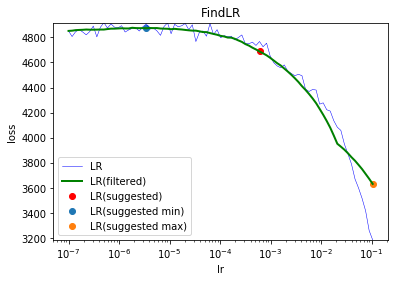

lr= 0.000602559586074358, lr_min=3.4673685045253164e-06, lr_max=0.10471285480508992


In [37]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, r_div=4, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
10	2872.98142440	2883.11749384	nan	34.964210
11	2875.33731399	2882.79472905	nan	35.121167
12	2875.14520342	2883.97931491	nan	35.270829
13	2873.60891388	2879.36027692	nan	34.964552
14	2872.81185062	2878.11540543	nan	34.515691
15	2872.03226528	2877.30481968	nan	35.069432
16	2871.49491800	2877.44174680	nan	35.116934
17	2870.69118615	2876.27940417	nan	34.983752
18	2870.40944412	2875.77613082	nan	35.324997
19	2870.03540039	2875.64288602	nan	35.134660


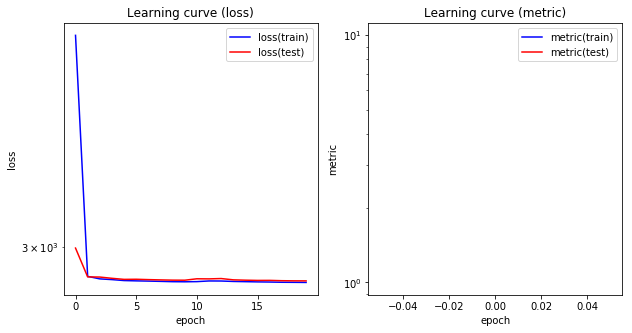

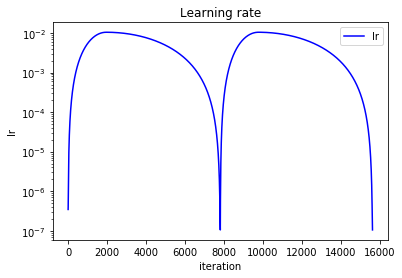

In [40]:
# lr_min,lr_max= 1.e-4, 3.e-3
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
# Fit(net, n_epoch=10, lr=1.e-3, 
#     opt=opt, f_loss=f_loss, f_metric=f_metric,
#     dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
#     callbacks=(logger.Callbacks(),disp.Callbacks()),
#     device=device)
logger.Plot()
logger.PlotLR()

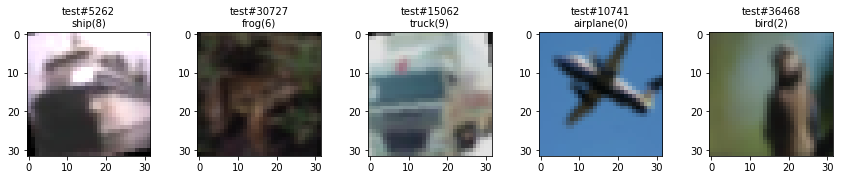

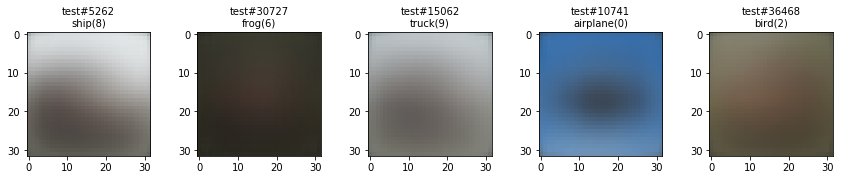

In [41]:
d= dset_train
# d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= torch.clamp(Eval(net,imgs,device=device)[0].cpu(),0,1)
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
plabels= [f'pred#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels, rows=1)
PlotImgGrid(pred, labels, rows=1)

# Comparison with Auto Encoder

In [2]:
class TResNetAE(torch.nn.Module):
  def __init__(self, in_imgshape, layers=[2, 2, 2, 2], encoder_args=None, decoder_args=None, latent_dim=256, n_hiddens=1, hidden_channels=768, p_dropout=0.0):
    super(TResNetAE,self).__init__()
    default_encoder_args= {'expansion':1}
    encoder_args= MergeDict(default_encoder_args,encoder_args) if encoder_args else default_encoder_args
    default_decoder_args= {'expansion':1}
    decoder_args= MergeDict(default_decoder_args,decoder_args) if decoder_args else default_decoder_args
    self.encoder= TResNet(TResBlock, **encoder_args, layers=layers, in_channels=in_imgshape[0], with_fc=False)
    ndim_encoder= torch.flatten(self.encoder(torch.zeros((3,)+tuple(in_imgshape))),1).shape[1]
    self.fc= torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Linear(ndim_encoder, hidden_channels),
          torch.nn.ReLU(),
          torch.nn.Dropout(p_dropout),
          *[TResDenseBlock(hidden_channels, hidden_channels) for i in range(n_hiddens)],
          torch.nn.Dropout(p_dropout),
          torch.nn.Linear(hidden_channels, latent_dim),
          )
    self.decoder= TResNetDecoder(TResBlock, **decoder_args, layers=layers, in_channels=latent_dim, out_imgshape=in_imgshape)

  def forward(self, x):
    x_encoded= self.encoder(x)
    h= self.fc(x_encoded)
    x_reconstructed= self.decoder(h)
    return x_reconstructed, h

class TAELoss(torch.nn.Module):
  def __init__(self):
    super(TAELoss,self).__init__()
  def state_dict(self):
    return {}
  def load_state_dict(self, d):
    pass
  def __call__(self, y_pred, y_trg):
    x_reconstructed,h= y_pred
    x= y_trg
    return torch.nn.functional.mse_loss(x_reconstructed, x)

## AE for MNIST

In [43]:
def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(32),
        torchvision.transforms.ToTensor()
      ])

In [44]:
dset_train= torchvision.datasets.MNIST(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.MNIST(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

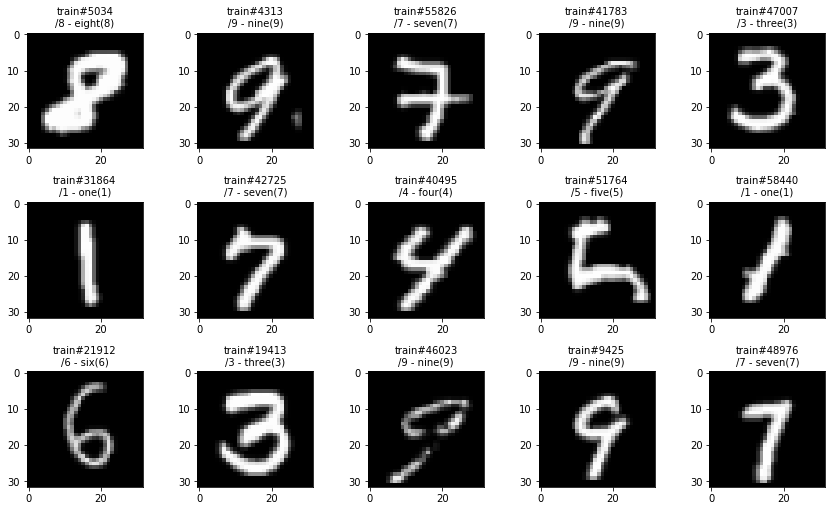

In [45]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

In [46]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResNetAE(in_imgshape=in_imgshape)

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TAELoss()
f_metric= None

def tfm_batch(batch):
  x,y= batch
  return x,x  #NOTE: We return x as the output to learn it.

logger= TLogger()
disp= TDisp()

In [47]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
net
torchinfo.summary(net, input_size)
# [y.shape for y in Eval(net,[dset_train[0][0]],device=device)]

input_size=(1, 1, 32, 32)


Layer (type:depth-idx)                             Output Shape              Param #
TResNetAE                                          --                        --
├─TResNet: 1-1                                     [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                            [1, 32, 32, 32]           288
│    │    └─BatchNorm2d: 3-2                       [1, 32, 32, 32]           64
│    │    └─ReLU: 3-3                              [1, 32, 32, 32]           --
│    └─Sequential: 2-2                             [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-4                            [1, 32, 16, 16]           9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 16, 16]           64
│    │    └─ReLU: 3-6                              [1, 32, 16, 16]           --
│    └─Sequential: 2-3                             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%


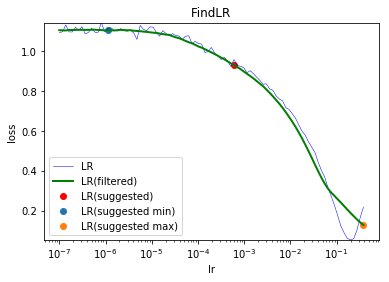

lr= 0.000602559586074358, lr_min=1.1220184543019633e-06, lr_max=0.3801893963205608


In [48]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, r_div=4, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	0.32807331	0.01756035	nan	38.686942
1	0.01502984	0.01244075	nan	38.650597
2	0.01074758	0.00973333	nan	38.834591
3	0.00874429	0.00830891	nan	39.029539
4	0.00770429	0.00733850	nan	39.192417
5	0.00682603	0.00596536	nan	39.267467
6	0.00601370	0.00585845	nan	38.890722
7	0.00510245	0.00429138	nan	38.486626
8	0.00433993	0.00361086	nan	38.787147
9	0.00377348	0.00345809	nan	39.087477


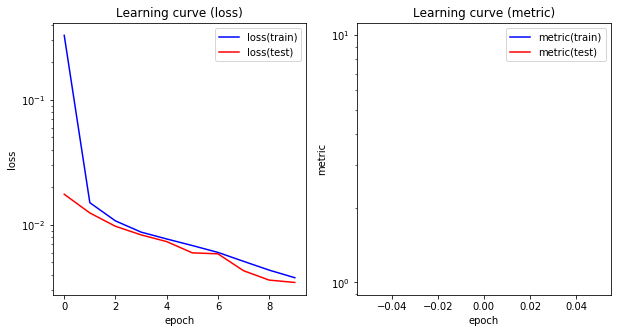

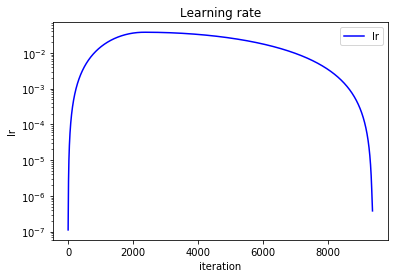

In [49]:
# lr_min,lr_max= 1.e-4, 3.e-3
lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
# Fit(net, n_epoch=10, lr=1.e-3, 
#     opt=opt, f_loss=f_loss, f_metric=f_metric,
#     dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
#     callbacks=(logger.Callbacks(),disp.Callbacks()),
#     device=device)
logger.Plot()
logger.PlotLR()

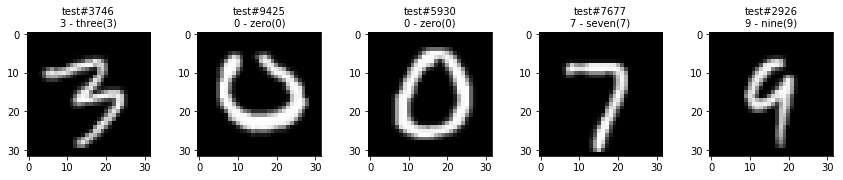

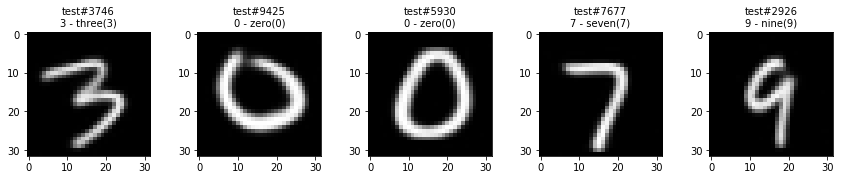

In [51]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= torch.clamp(Eval(net,imgs,device=device)[0].cpu(),0,1)
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
plabels= [f'pred#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels, rows=1)
PlotImgGrid(pred, labels, rows=1)

## AE for CIFAR-10

In [52]:
def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(64),
        torchvision.transforms.Pad(10, padding_mode='constant'),  #'reflect'
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomAffine(degrees=10, scale=(1.,1.1), shear=(-0.2,0.2,-0.2,0.2)),
        torchvision.transforms.CenterCrop(64),
        torchvision.transforms.RandomResizedCrop(32, scale=(0.75,1.), ratio=(1.,1.)),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(32),
        torchvision.transforms.ToTensor()
      ])

In [53]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


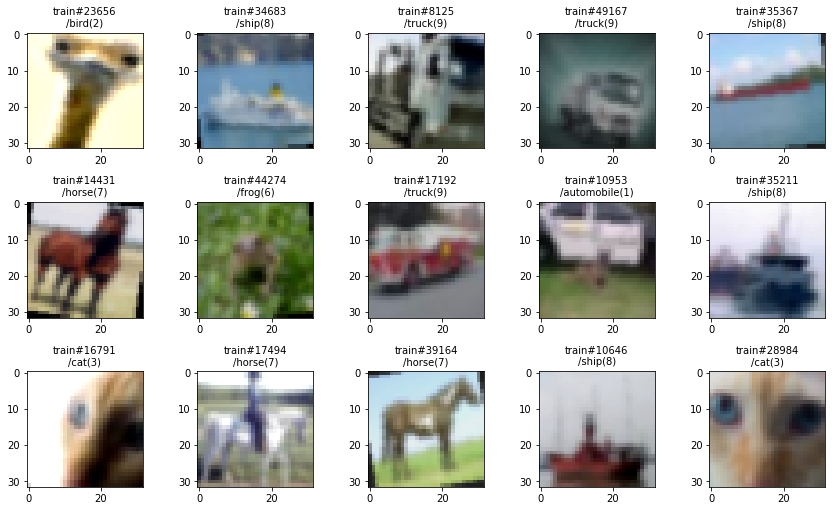

In [54]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

In [66]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResNetAE(in_imgshape=in_imgshape, latent_dim=512)

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TAELoss()
f_metric= None

def tfm_batch(batch):
  x,y= batch
  return x,x  #NOTE: We return x as the output to learn it.

logger= TLogger()
disp= TDisp()

In [67]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
net
torchinfo.summary(net, input_size)
# [y.shape for y in Eval(net,[dset_train[0][0]],device=device)]

input_size=(1, 3, 32, 32)


Layer (type:depth-idx)                             Output Shape              Param #
TResNetAE                                          --                        --
├─TResNet: 1-1                                     [1, 512, 1, 1]            --
│    └─Sequential: 2-1                             [1, 32, 32, 32]           --
│    │    └─Conv2d: 3-1                            [1, 32, 32, 32]           864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 32, 32]           64
│    │    └─ReLU: 3-3                              [1, 32, 32, 32]           --
│    └─Sequential: 2-2                             [1, 32, 16, 16]           --
│    │    └─Conv2d: 3-4                            [1, 32, 16, 16]           9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 16, 16]           64
│    │    └─ReLU: 3-6                              [1, 32, 16, 16]           --
│    └─Sequential: 2-3                             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%


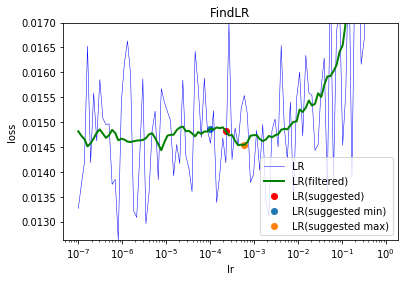

lr= 0.00022908676527677726, lr_min=0.0001023292992280754, lr_max=0.000602559586074358


In [73]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, r_div=4, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
40	0.01488396	0.01944437	nan	33.215541
41	0.01598428	0.02419494	nan	33.311563
42	0.01629089	0.02273465	nan	33.022608
43	0.01626946	0.01962517	nan	33.448345
44	0.01595595	0.01870799	nan	33.436382
45	0.01557209	0.01889294	nan	33.463005
46	0.01527469	0.01862398	nan	33.475703
47	0.01496295	0.01818204	nan	33.168264
48	0.01466833	0.01796529	nan	33.322365
49	0.01451287	0.01792563	nan	33.470609


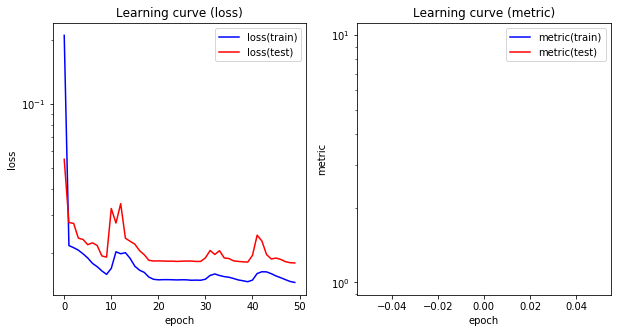

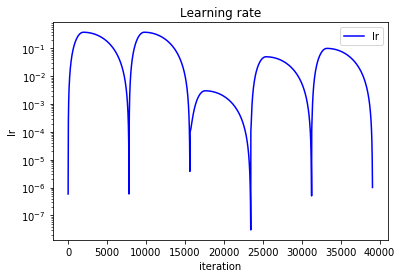

In [79]:
lr_min,lr_max= 1.e-4, 1.e-1
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
# Fit(net, n_epoch=10, lr=1.e-3, 
#     opt=opt, f_loss=f_loss, f_metric=f_metric,
#     dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
#     callbacks=(logger.Callbacks(),disp.Callbacks()),
#     device=device)
logger.Plot()
logger.PlotLR()

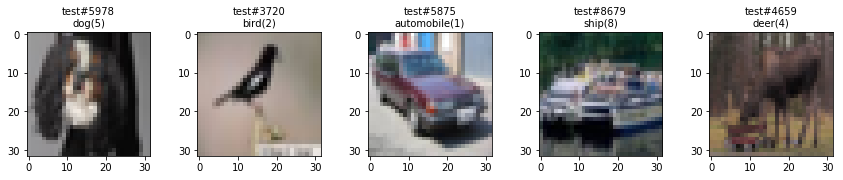

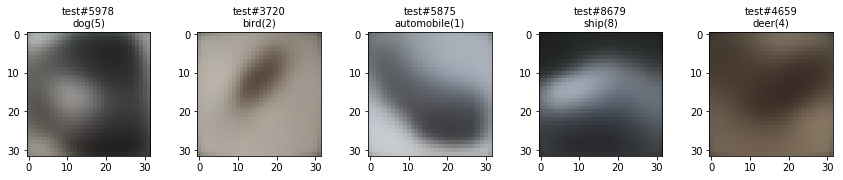

In [82]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= torch.clamp(Eval(net,imgs,device=device)[0].cpu(),0,1)
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
plabels= [f'pred#{i}\n{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels, rows=1)
PlotImgGrid(pred, labels, rows=1)

## AE for Handtest

In [107]:
from handtest_1 import HandtestDataset

def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((128,128)),
        # torchvision.transforms.Pad(10, padding_mode='constant'),  #'reflect'
        # torchvision.transforms.RandomHorizontalFlip(p=0.5),
        # torchvision.transforms.RandomAffine(degrees=10, scale=(1.,1.1), shear=(-0.2,0.2,-0.2,0.2)),
        # torchvision.transforms.CenterCrop(64),
        # torchvision.transforms.RandomResizedCrop(32, scale=(0.75,1.), ratio=(1.,1.)),
        # torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((128,128)),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop((128,128)),
        torchvision.transforms.ToTensor()
      ])

In [108]:
dset_train= HandtestDataset(transform=GetDataTransforms('train'), train=True)
dset_test= HandtestDataset(transform=GetDataTransforms('test'), train=False)

#NOTE: Adjust the batch size.
n_batch= 60
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

In [109]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] value range:',torch.min(dset_test[0][0]),torch.max(dset_test[0][0]))

dset_train size: 577
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 128, 128])
dset_train[0] value range: tensor(0.0078) tensor(0.9216)
dset_test size: 144
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 128, 128])
dset_test[0] value range: tensor(0.0157) tensor(0.9059)


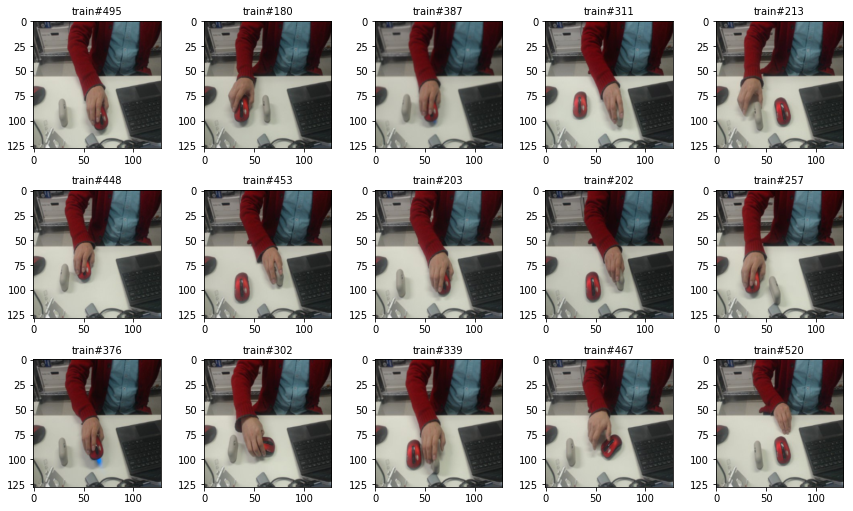

In [110]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}' for i in idxes]
PlotImgGrid(imgs, labels)

### latent_dim=252

In [111]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResNetAE(in_imgshape=in_imgshape, latent_dim=252, decoder_args=dict(stem_sizes=(64,64,32,32)))

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TAELoss()
f_metric= None

def tfm_batch(batch):
  x= batch[0]
  return x,x  #NOTE: We return x as the output to learn it.

logger= TLogger()
disp= TDisp()

In [112]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
# Eval(net, [dset_train[0][0]])[0]
torchinfo.summary(net, input_size)
# [y.shape for y in Eval(net,[dset_train[0][0]],device=device)]

input_size=(1, 3, 128, 128)


Layer (type:depth-idx)                             Output Shape              Param #
TResNetAE                                          --                        --
├─TResNet: 1-1                                     [1, 512, 2, 2]            --
│    └─Sequential: 2-1                             [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                            [1, 32, 128, 128]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 128, 128]         64
│    │    └─ReLU: 3-3                              [1, 32, 128, 128]         --
│    └─Sequential: 2-2                             [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-4                            [1, 32, 64, 64]           9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 64, 64]           64
│    │    └─ReLU: 3-6                              [1, 32, 64, 64]           --
│    └─Sequential: 2-3                             [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%


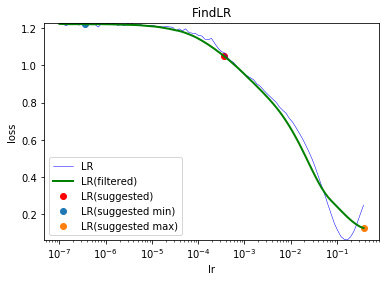

lr= 0.0003715352290971726, lr_min=3.630780547701013e-07, lr_max=0.3801893963205608


In [113]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, r_div=4, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
80	0.00570220	0.00569551	nan	1.399845
81	0.00579148	0.00570980	nan	1.326931
82	0.00572365	0.00571807	nan	1.307160
83	0.00600863	0.00591314	nan	1.310704
84	0.00608547	0.00583865	nan	1.331031
85	0.00601352	0.00643595	nan	1.328363
86	0.00598634	0.00589035	nan	1.329069
87	0.00603339	0.00739990	nan	1.326521
88	0.00631035	0.00991143	nan	1.336754
89	0.00608547	0.00711249	nan	1.334196
90	0.00634247	0.00715911	nan	1.322567
91	0.00640355	0.00653451	nan	1.340331
92	0.00616729	0.00613634	nan	1.324044
93	0.00620120	0.00662483	nan	1.324208
94	0.00645215	0.00840480	nan	1.327729
95	0.00621565	0.00777590	nan	1.307749
96	0.00593988	0.00706491	nan	1.306017
97	0.00595080	0.00670905	nan	1.321523
98	0.00607283	0.00679339	nan	1.324913
99	0.00587693	0.00692727	nan	1.322906
100	0.00608697	0.01185681	nan	1.325872
101	0.00606578	0.00656601	nan	1.334422
102	0.00606725	0.00687656	nan	1.391176
103	0.00587248	0.00623598	nan	1.319190
104	0.00571081	0.00573479	nan	1.306

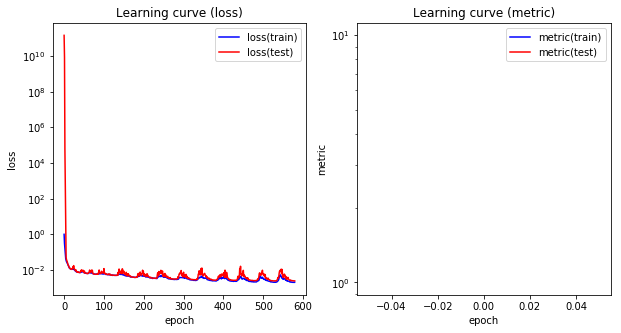

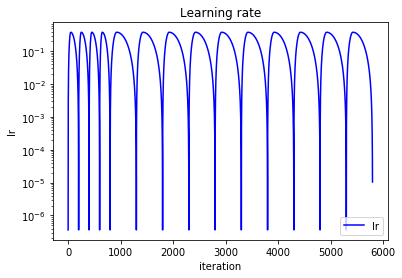

In [124]:
# lr_min,lr_max= 1.e-7, 1.e-6
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
for i in range(10):
  FitOneCycle(net, n_epoch=50, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
# Fit(net, n_epoch=10, lr=1.e-3, 
#     opt=opt, f_loss=f_loss, f_metric=f_metric,
#     dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
#     callbacks=(logger.Callbacks(),disp.Callbacks()),
#     device=device)
logger.Plot()
logger.PlotLR()

#### latent_dim=252

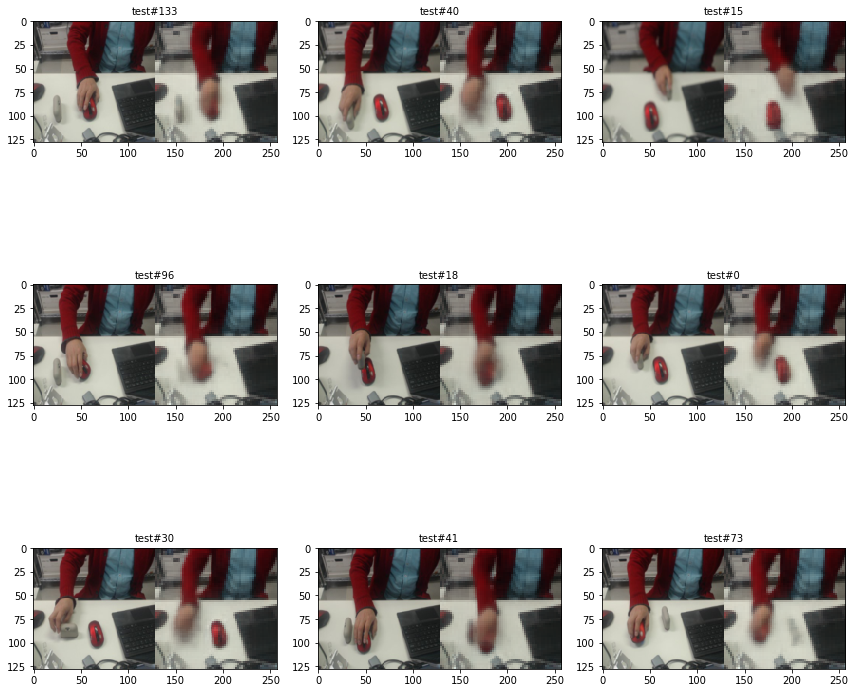

In [125]:
# d= dset_train
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= torch.clamp(Eval(net,imgs,device=device)[0].cpu(),0,1)
labels= [f'test#{i}' for i in idxes]
PlotImgGrid([HStackImages(img,x) for img,x in zip(imgs,pred)], labels, cols=3)

### latent_dim=15

In [126]:
#Setup a neural network.
in_imgshape= dset_train[0][0].shape
net= TResNetAE(in_imgshape=in_imgshape, latent_dim=15, decoder_args=dict(stem_sizes=(64,64,32,32)))

# #Load pretrained model parameters.
# url= 'https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth'
# net.load_state_dict(torchvision.models.utils.load_state_dict_from_url(url, map_location='cpu')['model'], strict=False)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
f_loss= TAELoss()
f_metric= None

def tfm_batch(batch):
  x= batch[0]
  return x,x  #NOTE: We return x as the output to learn it.

logger= TLogger()
disp= TDisp()

In [127]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
# Eval(net, [dset_train[0][0]])[0]
torchinfo.summary(net, input_size)
# [y.shape for y in Eval(net,[dset_train[0][0]],device=device)]

input_size=(1, 3, 128, 128)


Layer (type:depth-idx)                             Output Shape              Param #
TResNetAE                                          --                        --
├─TResNet: 1-1                                     [1, 512, 2, 2]            --
│    └─Sequential: 2-1                             [1, 32, 128, 128]         --
│    │    └─Conv2d: 3-1                            [1, 32, 128, 128]         864
│    │    └─BatchNorm2d: 3-2                       [1, 32, 128, 128]         64
│    │    └─ReLU: 3-3                              [1, 32, 128, 128]         --
│    └─Sequential: 2-2                             [1, 32, 64, 64]           --
│    │    └─Conv2d: 3-4                            [1, 32, 64, 64]           9,216
│    │    └─BatchNorm2d: 3-5                       [1, 32, 64, 64]           64
│    │    └─ReLU: 3-6                              [1, 32, 64, 64]           --
│    └─Sequential: 2-3                             [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-7        

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%


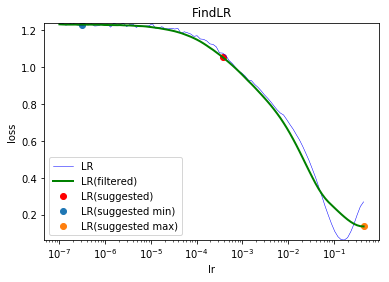

lr= 0.0003715352290971726, lr_min=3.090295432513591e-07, lr_max=0.4466835921509628


In [128]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, r_div=4, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(test)	time
0	1.09823025	109.61271922	nan	1.383645
1	0.69552439	3144386.00000000	nan	1.303938
2	0.27920233	17182.01236979	nan	1.288087
3	0.05702238	3.73532653	nan	1.277864
4	0.06858093	0.04298940	nan	1.321021
5	0.03111474	0.16406439	nan	1.324344
6	0.02192642	0.02635032	nan	1.278764
7	0.01233980	0.01841868	nan	1.285859
8	0.00977808	0.01920356	nan	1.268270
9	0.00813879	0.01296233	nan	1.304499
10	0.00780796	0.01078964	nan	1.299035
11	0.00695371	0.00871601	nan	1.255073
12	0.00641816	0.01038504	nan	1.283654
13	0.00609835	0.00741287	nan	1.273755
14	0.00608222	0.01107514	nan	1.298564
15	0.00574413	0.00754052	nan	1.305844
16	0.00552325	0.00634532	nan	1.286513
17	0.00540105	0.00653455	nan	1.312569
18	0.00527918	0.00550926	nan	1.307600
19	0.00518227	0.00663882	nan	1.312258
20	0.00498773	0.00613818	nan	1.307110
21	0.00467338	0.00738299	nan	1.295572
22	0.00475303	0.00552783	nan	1.283535
23	0.00452781	0.00533028	nan	1.290587
24	0.00436414	0.00488305	nan	1.275807

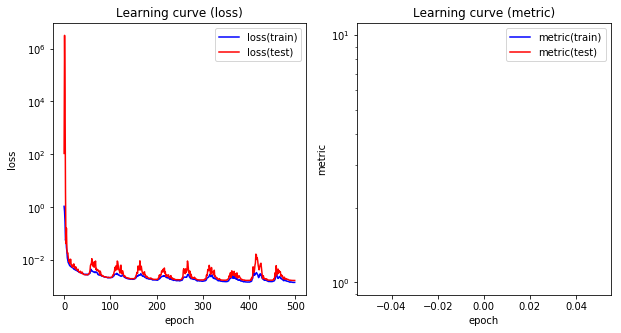

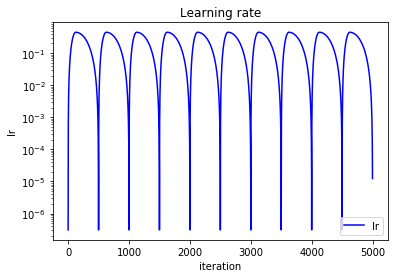

In [129]:
# lr_min,lr_max= 1.e-7, 1.e-6
# lr_min,lr_max= lr_min*1e-1,lr_max*1e-1
for i in range(10):
  FitOneCycle(net, n_epoch=50, lr_max=lr_max, div_init=lr_max/lr_min, 
      opt=opt, f_loss=f_loss, f_metric=f_metric,
      dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
      callbacks=(logger.Callbacks(),disp.Callbacks()),
      device=device)
# Fit(net, n_epoch=10, lr=1.e-3, 
#     opt=opt, f_loss=f_loss, f_metric=f_metric,
#     dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
#     callbacks=(logger.Callbacks(),disp.Callbacks()),
#     device=device)
logger.Plot()
logger.PlotLR()

#### latent_dim=15

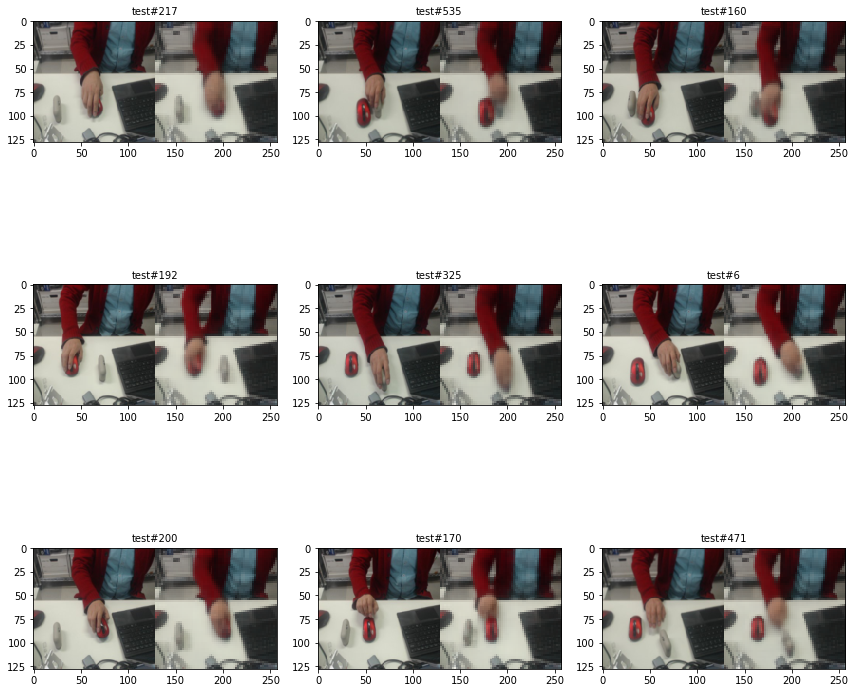

In [133]:
d= dset_train
# d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= torch.clamp(Eval(net,imgs,device=device)[0].cpu(),0,1)
labels= [f'test#{i}' for i in idxes]
PlotImgGrid([HStackImages(img,x) for img,x in zip(imgs,pred)], labels, cols=3)